In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from pymongo import MongoClient
import time
import datetime
import os
from pyculiarity import detect_ts
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from src.dendrogram_class import Dendrogram, make_dendrogram, mask_mins
import pickle
import itertools
from collections import defaultdict, Counter
import scipy.stats as scs
from scipy import signal
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score, silhouette_samples
from pyramid.arima import auto_arima
from IPython.display import HTML, display
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
with open('../data/cs_df_M.pkl', 'rb') as f:
    df = pickle.load(f)

In [4]:
df[~df.gun_bool].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3052994 entries, 2339 to 8881813
Data columns (total 18 columns):
item_name             object
date_str              object
median_sell_price     float64
quantity              int64
est_release_str       object
days_since_release    int64
gun_type              object
skin                  object
quality               object
gun_bool              bool
StatTrak              bool
souvenir              bool
keys                  bool
capsules              bool
stickers              bool
date                  float64
est_release           float64
timestamp             datetime64[ns]
dtypes: bool(6), datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 320.3+ MB


In [5]:
df['desc'] = df['item_name'] + ' ' + df['est_release_str']

In [6]:
anomaly_full = df[df.days_since_release > 30]

In [7]:
anomaly_full = mask_mins(anomaly_full, 0.1, 50)
anomaly_full = anomaly_full[anomaly_full.est_release < time.mktime(datetime.datetime.strptime('15 February 2018', "%d %B %Y").timetuple())] # not enough points
items = anomaly_full.item_name.unique()

In [8]:
anom_list = []
for item in items:
    temp_df = anomaly_full[anomaly_full.item_name == item]
    temp_df = temp_df[['timestamp', 'median_sell_price']].reset_index(drop=True)
    results = detect_ts(temp_df, max_anoms=0.3, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)
    if len(results['anoms'].index)>1 and results['anoms'].index[0] != temp_df['timestamp'][0]:
        anom_list += results['anoms'].index[1:]
    elif len(results['anoms'].index) > 0:
        anom_list += results['anoms'].index

In [9]:
anom_delta_dict = {}
for day in set(anom_list):
    start, end = day - datetime.timedelta(3), day + datetime.timedelta(3)
    anom_delta_dict[day]= sum(x >= start and x <= end for x in anom_list)
sorted_list = sorted(anom_delta_dict.items(), key=lambda x: x[1], reverse=True)
return_list = [sorted_list[0]]
for day in sorted_list[1:]:
    start, end = day[0] - datetime.timedelta(6), day[0] + datetime.timedelta(6)
    if any(x[0] >= start and x[0] <= end for x in return_list):
        continue
    else:
        return_list.append(day)
print(*[(x.date().strftime('%d %b %Y'), y) for x, y in sorted(return_list[:30])], sep='\n')

('19 Jun 2015', 275)
('14 Aug 2015', 244)
('21 Aug 2015', 623)
('01 Nov 2015', 276)
('29 Nov 2015', 596)
('02 Jan 2016', 365)
('09 Feb 2016', 694)
('16 Feb 2016', 263)
('07 Mar 2016', 429)
('13 May 2016', 373)
('21 Jun 2016', 290)
('08 Oct 2016', 270)
('31 Oct 2016', 497)
('27 Nov 2016', 900)
('21 Dec 2016', 268)
('27 Jan 2017', 408)
('19 Feb 2017', 281)
('20 Mar 2017', 302)
('15 May 2017', 237)
('22 May 2017', 607)
('26 Jun 2017', 344)
('25 Jul 2017', 235)
('05 Sep 2017', 268)
('22 Oct 2017', 484)
('26 Nov 2017', 628)
('24 Dec 2017', 373)
('25 Feb 2018', 283)
('30 Mar 2018', 344)
('06 May 2018', 260)
('25 Jun 2018', 805)


In [10]:
print(*[(x.date().strftime('%d %b %Y'), y) for x, y in return_list[:30]], sep='\n')

('27 Nov 2016', 900)
('25 Jun 2018', 805)
('09 Feb 2016', 694)
('26 Nov 2017', 628)
('21 Aug 2015', 623)
('22 May 2017', 607)
('29 Nov 2015', 596)
('31 Oct 2016', 497)
('22 Oct 2017', 484)
('07 Mar 2016', 429)
('27 Jan 2017', 408)
('13 May 2016', 373)
('24 Dec 2017', 373)
('02 Jan 2016', 365)
('26 Jun 2017', 344)
('30 Mar 2018', 344)
('20 Mar 2017', 302)
('21 Jun 2016', 290)
('25 Feb 2018', 283)
('19 Feb 2017', 281)
('01 Nov 2015', 276)
('19 Jun 2015', 275)
('08 Oct 2016', 270)
('21 Dec 2016', 268)
('05 Sep 2017', 268)
('16 Feb 2016', 263)
('06 May 2018', 260)
('14 Aug 2015', 244)
('15 May 2017', 237)
('25 Jul 2017', 235)


### What happens if I weight the anomalies by the quantity sold?

In [11]:
anomaly_full = df[df.days_since_release > 30]

In [12]:
anomaly_full = mask_mins(anomaly_full, 0.1, 25)
anomaly_full = anomaly_full[anomaly_full.est_release < time.mktime(datetime.datetime.strptime('15 February 2018', "%d %B %Y").timetuple())] # not enough points
items = anomaly_full.item_name.unique()

In [13]:
def anom_detect(df, item):
    fit_df = df[df.item_name == item]
    fit_df = fit_df[['timestamp', 'median_sell_price']].reset_index(drop=True)
    return detect_ts(fit_df, max_anoms=0.3, alpha=0.001, direction='both', only_last=None, longterm=True, verbose=True, piecewise_median_period_weeks=3)

In [14]:
anom_dict = defaultdict(lambda: 0)
for item in items:
    temp_df = anomaly_full[anomaly_full.item_name == item]
    results = anom_detect(temp_df, item)
    if len(results['anoms'].index)>0:
        for anomaly in results['anoms'].index:
            if anomaly != temp_df['date'].iloc[0]:
                anom_dict[anomaly] += temp_df[[datetime.datetime.fromtimestamp(t) == anomaly for t in temp_df.date]].quantity.values[0]
                #anom_dict[anomaly + datetime.timedelta(3)] += temp_df[temp_df.date == anomaly.timestamp()]
                #anom_dict[anomaly - datetime.timedelta(3)] += temp_df[temp_df.date == anomaly.timestamp()]

In [15]:
sorted(anom_dict.items(), key=lambda x: x[1], reverse=True)[:30]

[(Timestamp('2015-08-23 00:00:00'), 306904),
 (Timestamp('2016-02-18 00:00:00'), 279713),
 (Timestamp('2015-08-24 00:00:00'), 270927),
 (Timestamp('2015-11-28 00:00:00'), 260527),
 (Timestamp('2015-11-01 00:00:00'), 245531),
 (Timestamp('2015-11-27 00:00:00'), 244783),
 (Timestamp('2015-11-29 00:00:00'), 243636),
 (Timestamp('2016-02-07 00:00:00'), 224786),
 (Timestamp('2015-08-21 00:00:00'), 224400),
 (Timestamp('2015-08-15 00:00:00'), 215116),
 (Timestamp('2015-08-22 00:00:00'), 200142),
 (Timestamp('2016-02-09 00:00:00'), 196869),
 (Timestamp('2016-02-08 00:00:00'), 187392),
 (Timestamp('2015-11-26 00:00:00'), 186022),
 (Timestamp('2015-11-30 00:00:00'), 184389),
 (Timestamp('2016-02-10 00:00:00'), 184328),
 (Timestamp('2015-11-02 00:00:00'), 183548),
 (Timestamp('2015-08-16 00:00:00'), 175947),
 (Timestamp('2015-05-27 00:00:00'), 175675),
 (Timestamp('2016-01-04 00:00:00'), 173641),
 (Timestamp('2016-01-03 00:00:00'), 171063),
 (Timestamp('2015-08-25 00:00:00'), 170822),
 (Timestam

In [16]:
anom_delta_dict = {}
for day in set(anom_list):
    start, end = day - datetime.timedelta(3), day + datetime.timedelta(3)
    anom_delta_dict[day]= sum(x >= start and x <= end for x in anom_list)
sorted_list = sorted(anom_delta_dict.items(), key=lambda x: x[1], reverse=True)
return_list = [sorted_list[0]]
for day in sorted_list[1:]:
    start, end = day[0] - datetime.timedelta(6), day[0] + datetime.timedelta(6)
    if any(x[0] >= start and x[0] <= end for x in return_list):
        continue
    else:
        return_list.append(day)
print(*[(x.date().strftime('%d %b %Y'), y) for x, y in sorted(return_list[:30])], sep='\n')

('19 Jun 2015', 275)
('14 Aug 2015', 244)
('21 Aug 2015', 623)
('01 Nov 2015', 276)
('29 Nov 2015', 596)
('02 Jan 2016', 365)
('09 Feb 2016', 694)
('16 Feb 2016', 263)
('07 Mar 2016', 429)
('13 May 2016', 373)
('21 Jun 2016', 290)
('08 Oct 2016', 270)
('31 Oct 2016', 497)
('27 Nov 2016', 900)
('21 Dec 2016', 268)
('27 Jan 2017', 408)
('19 Feb 2017', 281)
('20 Mar 2017', 302)
('15 May 2017', 237)
('22 May 2017', 607)
('26 Jun 2017', 344)
('25 Jul 2017', 235)
('05 Sep 2017', 268)
('22 Oct 2017', 484)
('26 Nov 2017', 628)
('24 Dec 2017', 373)
('25 Feb 2018', 283)
('30 Mar 2018', 344)
('06 May 2018', 260)
('25 Jun 2018', 805)


In [17]:
print(*[(x.date().strftime('%d %b %Y'), y) for x, y in return_list[:30]], sep='\n')

('27 Nov 2016', 900)
('25 Jun 2018', 805)
('09 Feb 2016', 694)
('26 Nov 2017', 628)
('21 Aug 2015', 623)
('22 May 2017', 607)
('29 Nov 2015', 596)
('31 Oct 2016', 497)
('22 Oct 2017', 484)
('07 Mar 2016', 429)
('27 Jan 2017', 408)
('13 May 2016', 373)
('24 Dec 2017', 373)
('02 Jan 2016', 365)
('26 Jun 2017', 344)
('30 Mar 2018', 344)
('20 Mar 2017', 302)
('21 Jun 2016', 290)
('25 Feb 2018', 283)
('19 Feb 2017', 281)
('01 Nov 2015', 276)
('19 Jun 2015', 275)
('08 Oct 2016', 270)
('21 Dec 2016', 268)
('05 Sep 2017', 268)
('16 Feb 2016', 263)
('06 May 2018', 260)
('14 Aug 2015', 244)
('15 May 2017', 237)
('25 Jul 2017', 235)


#### Investigating November 2015

In [18]:
df[df.est_release < time.mktime(datetime.datetime.strptime('1 November 2015', "%d %B %Y").timetuple())].head()

,item_name,date_str,median_sell_price,quantity,est_release_str,days_since_release,gun_type,skin,quality,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release,timestamp,desc
3802,Dual Berettas | Moon in Libra (Field-Tested),27 May 2015,0.285,1573,27 May 2015,0,Dual Berettas,Moon in Libra,Field-Tested,True,False,False,False,False,False,1.432703e+09,1.432703e+09,2015-05-27,Dual Berettas | Moon in Libra (Field-Tested) 2...
3803,Dual Berettas | Moon in Libra (Field-Tested),28 May 2015,0.278,1488,27 May 2015,1,Dual Berettas,Moon in Libra,Field-Tested,True,False,False,False,False,False,1.432789e+09,1.432703e+09,2015-05-28,Dual Berettas | Moon in Libra (Field-Tested) 2...
3804,Dual Berettas | Moon in Libra (Field-Tested),29 May 2015,0.373,877,27 May 2015,2,Dual Berettas,Moon in Libra,Field-Tested,True,False,False,False,False,False,1.432876e+09,1.432703e+09,2015-05-29,Dual Berettas | Moon in Libra (Field-Tested) 2...
3805,Dual Berettas | Moon in Libra (Field-Tested),30 May 2015,0.445,663,27 May 2015,3,Dual Berettas,Moon in Libra,Field-Tested,True,False,False,False,False,False,1.432962e+09,1.432703e+09,2015-05-30,Dual Berettas | Moon in Libra (Field-Tested) 2...
3806,Dual Berettas | Moon in Libra (Field-Tested),31 May 2015,0.526,479,27 May 2015,4,Dual Berettas,Moon in Libra,Field-Tested,True,False,False,False,False,False,1.433048e+09,1.432703e+09,2015-05-31,Dual Berettas | Moon in Libra (Field-Tested) 2...


In [19]:
x = df[df.item_name=='Dual Berettas | Moon in Libra (Field-Tested)']['timestamp']

In [20]:
y = df[df.item_name=='Dual Berettas | Moon in Libra (Field-Tested)'].median_sell_price

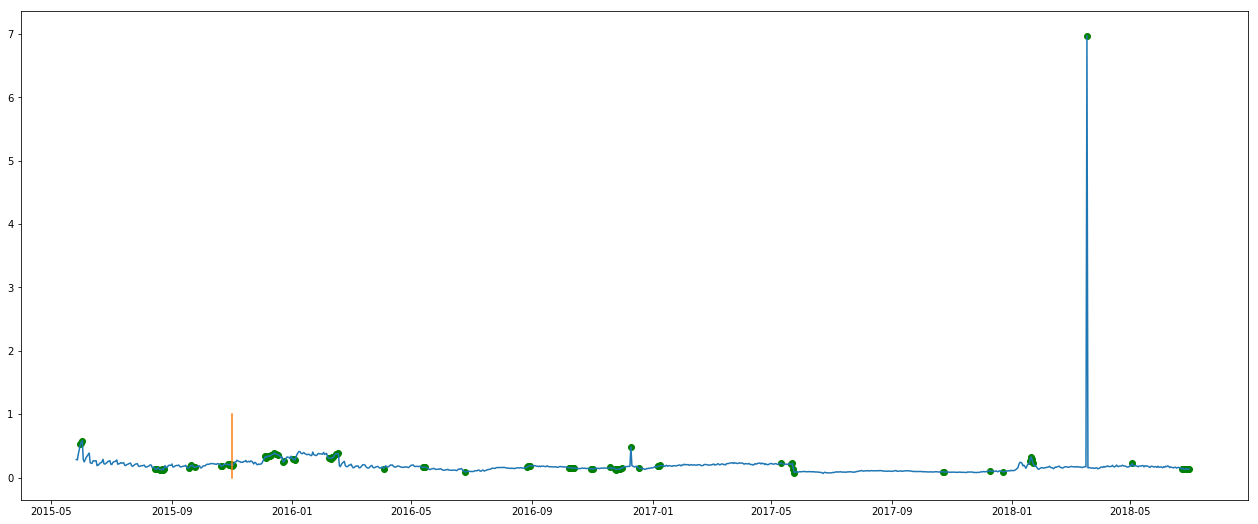

In [21]:
results = anom_detect(df[df['item_name'] == 'Dual Berettas | Moon in Libra (Field-Tested)'], 'Dual Berettas | Moon in Libra (Field-Tested)')
fig, ax = plt.subplots(figsize=(22, 9))
ax.plot(x, y)
ax.plot([np.datetime64(datetime.datetime.fromtimestamp(time.mktime(datetime.datetime.strptime('1 November 2015', "%d %B %Y").timetuple())).date())]*2, [0,1])
ax.scatter(results['anoms'].index, results['anoms']['anoms'], c='green')

### Auto arima outlier comparison

In [22]:
compare_df = df[df['item_name'] == 'Dual Berettas | Moon in Libra (Field-Tested)']
compare_df.loc[4828, 'median_sell_price'] = np.median(compare_df.median_sell_price)

In [23]:

model = auto_arima(compare_df.median_sell_price)
resid_df = pd.DataFrame({'timestamp': compare_df.timestamp, 'resid': model.resid(), 'raw': compare_df.median_sell_price, 'pred': model.predict_in_sample()})

mean = np.mean(resid_df.raw[1:])
std = np.std(resid_df.raw[1:])
outliers = resid_df[(resid_df.raw > mean + 3*std) | (resid_df.raw < mean - 3*std)]

In [24]:
base = datetime.datetime(2018, 7, 1)
arr = np.arange(datetime.datetime(2018,7,1), datetime.datetime(2019,1,1), datetime.timedelta(days=1)).astype(datetime.datetime)

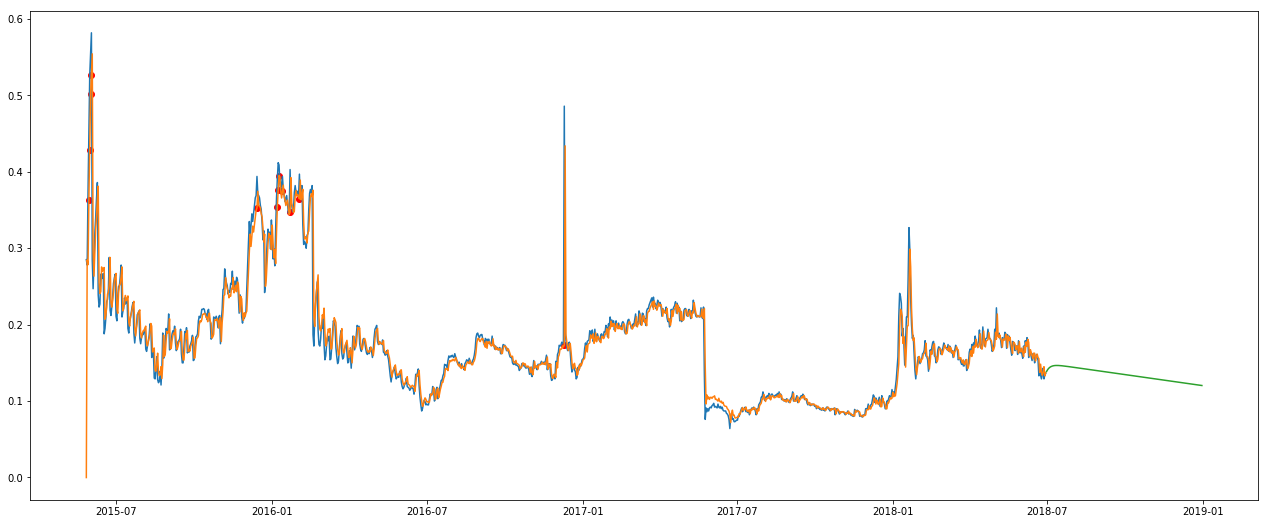

In [25]:
fig, ax = plt.subplots(figsize=(22,9))
ax.plot(compare_df.timestamp, compare_df.median_sell_price)
ax.plot(compare_df.timestamp, compare_df.median_sell_price - model.resid())
ax.plot(arr, model.predict(n_periods=len(arr)))
ax.scatter(outliers.timestamp.values, outliers.pred.values, c='red')

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1131
Model:               SARIMAX(1, 1, 1)   Log Likelihood                2734.417
Date:                Tue, 13 Nov 2018   AIC                          -5460.833
Time:                        17:22:34   BIC                          -5440.713
Sample:                             0   HQIC                         -5453.232
                               - 1131                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.167e-05    4.2e-05     -0.754      0.451      -0.000    5.07e-05
ar.L1          0.7992      0.013     60.577      0.000       0.773       0.825
ma.L1         -0.9535      0.011    -88.893      0.000      -0.975      -0.932
sigma2         0.0005   3.73e-06    124.205      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                      186.60   Jarque-Bera (JB):            314712.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -1.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        84.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

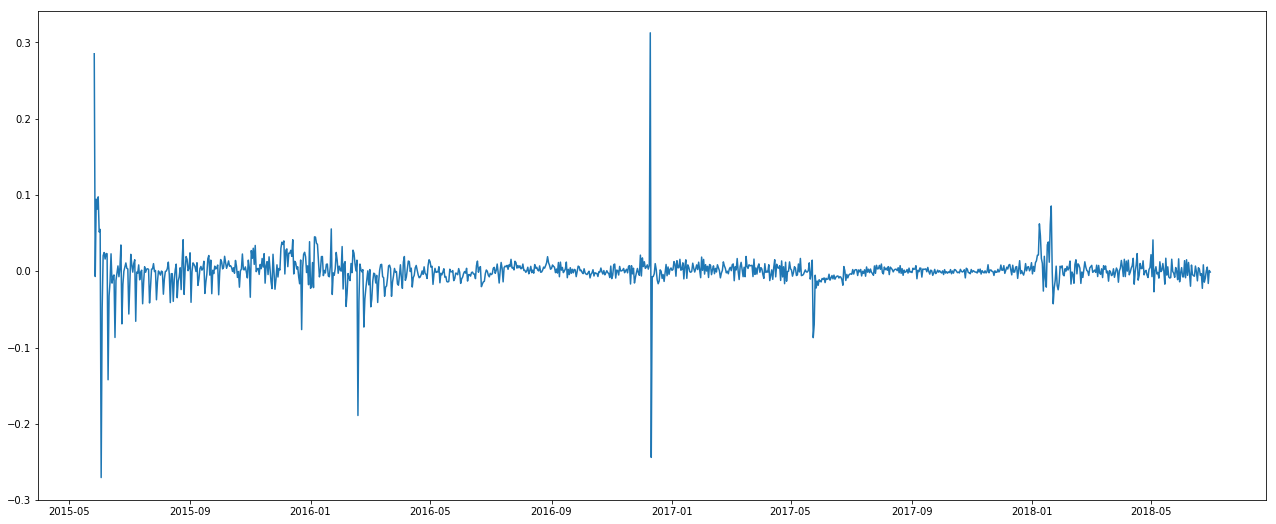

In [27]:
fig, ax = plt.subplots(figsize=(22,9))
ax.plot(compare_df.timestamp, model.resid())

### Number of items available on a given day

In [29]:
with open('../archive/anomalies.pkl', 'rb') as f:
    anomalies = pickle.load(f)

In [30]:
df_num_items = df.groupby('item_name').agg('median')

In [31]:
df_num_items.head()

,median_sell_price,quantity,days_since_release,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release
item_name,,,,,,,,,,,
AK-47 | Aquamarine Revenge (Battle-Scarred),11.536,106.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09
AK-47 | Aquamarine Revenge (Factory New),36.005,36.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09
AK-47 | Aquamarine Revenge (Field-Tested),17.574,249.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09
AK-47 | Aquamarine Revenge (Minimal Wear),24.727,120.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09
AK-47 | Aquamarine Revenge (Well-Worn),14.590,133.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09


In [32]:
index = [pd.to_datetime(t, unit='s') for t in df_num_items.est_release]

In [33]:
df_num_items['release_timestamp'] = index

In [34]:
df_num_items['release_timestamp'] = [t.date() for t in df_num_items['release_timestamp']]

In [35]:
df_num_items.head()

,median_sell_price,quantity,days_since_release,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release,release_timestamp
item_name,,,,,,,,,,,,
AK-47 | Aquamarine Revenge (Battle-Scarred),11.536,106.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09,2015-05-27
AK-47 | Aquamarine Revenge (Factory New),36.005,36.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09,2015-05-27
AK-47 | Aquamarine Revenge (Field-Tested),17.574,249.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09,2015-05-27
AK-47 | Aquamarine Revenge (Minimal Wear),24.727,120.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09,2015-05-27
AK-47 | Aquamarine Revenge (Well-Worn),14.590,133.0,565.0,True,False,False,False,False,False,1.481522e+09,1.432703e+09,2015-05-27


In [36]:
df_num_items = df_num_items.groupby('release_timestamp').count()

In [37]:
df_num_items['total_released'] = np.cumsum(df_num_items.median_sell_price)

In [38]:
df_num_items.head()

,median_sell_price,quantity,days_since_release,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release,total_released
release_timestamp,,,,,,,,,,,,
2013-04-26,1,1,1,1,1,1,1,1,1,1,1,1
2013-08-13,5,5,5,5,5,5,5,5,5,5,5,6
2013-08-14,47,47,47,47,47,47,47,47,47,47,47,53
2013-08-15,249,249,249,249,249,249,249,249,249,249,249,302
2013-08-16,55,55,55,55,55,55,55,55,55,55,55,357


In [39]:
num_items = df_num_items.total_released

In [40]:
num_items = num_items.reset_index()

In [41]:
num_items['timestamp'] = [pd.to_datetime(t) for t in num_items['release_timestamp']]

In [42]:
num_items.head()

,release_timestamp,total_released,timestamp
0,2013-04-26,1,2013-04-26
1,2013-08-13,6,2013-08-13
2,2013-08-14,53,2013-08-14
3,2013-08-15,302,2013-08-15
4,2013-08-16,357,2013-08-16


In [43]:
num_items = num_items.drop(columns='release_timestamp')

In [44]:
anomalies[0]

(Timestamp('2017-05-25 00:00:00'), 260)

In [45]:
scaled_anom_dict = {}
for x, y in anomalies:
    scaled_anom_dict[x] = y / np.max(num_items[num_items.timestamp <= x]['total_released'])

In [46]:
sorted_list = sorted(scaled_anom_dict.items(), key=lambda x: x[1], reverse=True)
print(*[(x.date().strftime('%d %b %Y'), '{:.3f}'.format(y)) for x, y in sorted_list[:30]], sep='\n')

('25 May 2017', '0.028')
('28 Nov 2015', '0.026')
('29 Nov 2015', '0.024')
('27 Nov 2015', '0.023')
('30 Nov 2015', '0.023')
('01 Dec 2015', '0.022')
('27 Nov 2016', '0.021')
('28 Nov 2016', '0.021')
('29 Nov 2016', '0.021')
('26 Nov 2016', '0.021')
('29 Jun 2018', '0.020')
('26 May 2017', '0.020')
('30 Nov 2016', '0.019')
('28 Jun 2018', '0.019')
('25 Nov 2017', '0.019')
('27 Jun 2018', '0.018')
('30 Jun 2018', '0.018')
('26 Nov 2017', '0.018')
('15 Mar 2016', '0.017')
('24 Nov 2017', '0.017')
('24 Jun 2017', '0.017')
('17 Mar 2016', '0.017')
('27 Nov 2017', '0.017')
('16 Mar 2016', '0.017')
('02 Dec 2015', '0.017')
('28 Nov 2017', '0.016')
('25 Nov 2016', '0.016')
('01 Nov 2016', '0.016')
('26 Jun 2018', '0.016')
('31 Oct 2016', '0.016')


In [47]:
from src.arima_anom_detect import get_num_items_per_day

In [48]:
num = get_num_items_per_day(df)

In [49]:
num.head()

,release_timestamp,total_released
0,2013-04-26,1
1,2013-08-13,6
2,2013-08-14,53
3,2013-08-15,302
4,2013-08-16,357


In [50]:
num['added'] = num['total_released'].diff()

In [51]:
num.index = num['release_timestamp']

In [52]:
num = num.drop(columns=['release_timestamp', 'total_released'])

In [53]:
num.sort_values('added', ascending=False, inplace=True)

In [54]:
expected = num.iloc[:30]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c289b73c8>]],
      dtype=object)

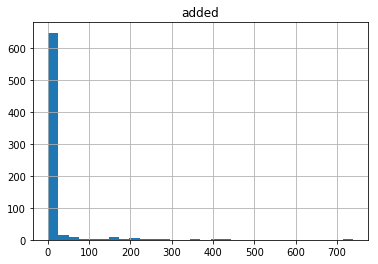

In [55]:
num.hist(bins=30)

In [56]:
num.iloc[0:33]

,added
release_timestamp,
2016-10-07,738.0
2013-11-28,442.0
2017-12-20,400.0
2015-05-27,400.0
2014-07-02,361.0
2017-07-07,291.0
2013-08-15,249.0
2017-01-13,248.0
2016-03-18,231.0


In [57]:
[x.date().strftime('%d %b %Y') for x in sorted(expected.index)]

['15 Aug 2013',
 '28 Nov 2013',
 '29 Nov 2013',
 '30 Nov 2013',
 '19 Dec 2013',
 '02 May 2014',
 '02 Jul 2014',
 '12 Nov 2014',
 '09 Jan 2015',
 '16 Apr 2015',
 '27 May 2015',
 '15 Aug 2015',
 '18 Sep 2015',
 '21 Oct 2015',
 '09 Dec 2015',
 '18 Feb 2016',
 '18 Mar 2016',
 '28 Apr 2016',
 '16 Jun 2016',
 '25 Jun 2016',
 '19 Aug 2016',
 '07 Oct 2016',
 '29 Nov 2016',
 '13 Jan 2017',
 '16 Mar 2017',
 '24 May 2017',
 '07 Jul 2017',
 '15 Sep 2017',
 '20 Dec 2017',
 '16 Feb 2018']

### Exogenous testing

In [58]:
with open('../data/cs_df_M.pkl', 'rb') as f:
    df = pickle.load(f)

In [59]:
from pyculiarity import detect_ts
from pyramid.arima import auto_arima

In [60]:
anom_val = df[df.item_name=='AWP | Redline (Field-Tested)']

In [61]:
anom_val.head()

,item_name,date_str,median_sell_price,quantity,est_release_str,days_since_release,gun_type,skin,quality,gun_bool,StatTrak,souvenir,keys,capsules,stickers,date,est_release,timestamp
1070474,AWP | Redline (Field-Tested),19 Dec 2013,34.722,35,19 Dec 2013,0,AWP,Redline,Field-Tested,True,False,False,False,False,False,1.387433e+09,1.387433e+09,2013-12-19
1070475,AWP | Redline (Field-Tested),20 Dec 2013,28.613,61,19 Dec 2013,1,AWP,Redline,Field-Tested,True,False,False,False,False,False,1.387519e+09,1.387433e+09,2013-12-20
1070476,AWP | Redline (Field-Tested),21 Dec 2013,21.459,81,19 Dec 2013,2,AWP,Redline,Field-Tested,True,False,False,False,False,False,1.387606e+09,1.387433e+09,2013-12-21
1070477,AWP | Redline (Field-Tested),22 Dec 2013,19.542,79,19 Dec 2013,3,AWP,Redline,Field-Tested,True,False,False,False,False,False,1.387692e+09,1.387433e+09,2013-12-22
1070478,AWP | Redline (Field-Tested),23 Dec 2013,18.589,92,19 Dec 2013,4,AWP,Redline,Field-Tested,True,False,False,False,False,False,1.387778e+09,1.387433e+09,2013-12-23


In [62]:
auto_arima
df_val = anom_val[['timestamp', 'median_sell_price']]
model = auto_arima(df_val['median_sell_price'][30:], exogenous=anom_val['quantity'][30:].values.reshape(-1,1))
df_detect = pd.DataFrame({'timestamp': df_val['timestamp'][31:].values, 'value':model.predict_in_sample(start=1, exogenous=anom_val['quantity'][31:].values.reshape(-1,1), dynamic=True)})
results = detect_ts(df_detect, max_anoms=0.3, alpha=0.001, direction='both', only_last=None,
                     longterm=True, verbose=True, piecewise_median_period_weeks=3)

Text(0.5, 1.0, 'AWP | Redline (Field-Tested) Anomaly Detection')

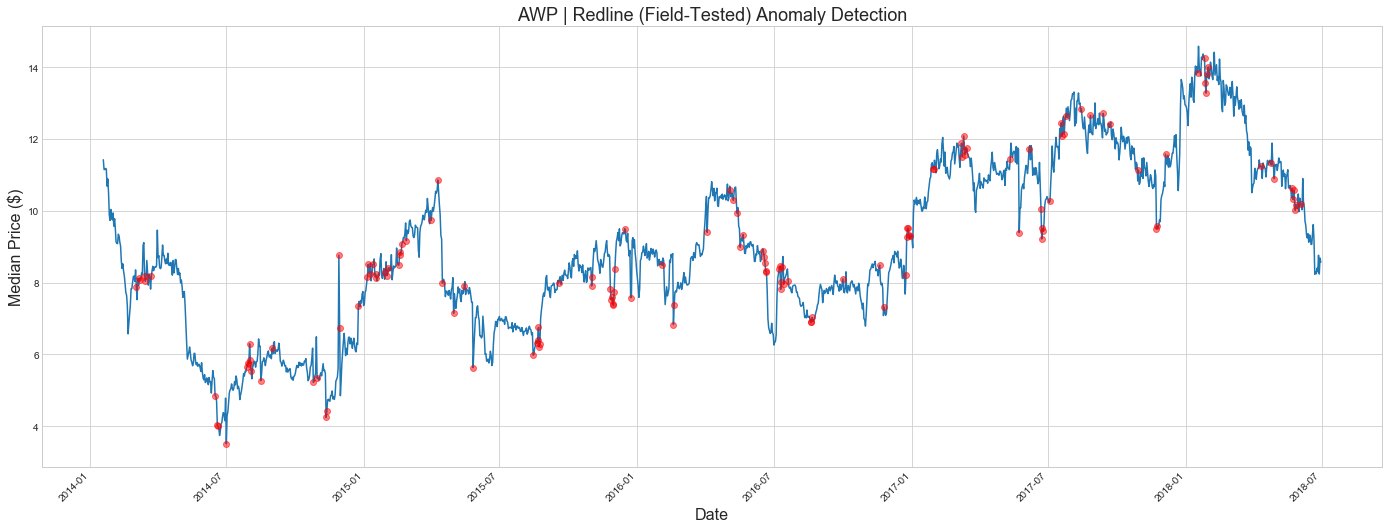

In [63]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(24,9))
fig.autofmt_xdate(rotation=45)
ax.plot(anom_val.timestamp[31:], anom_val.median_sell_price[31:], zorder=1)
# ax.plot(anom_val.timestamp[31:], model.predict_in_sample(start=1, exogenous=anom_val['quantity'][31:].values.reshape(-1,1)), c='black', zorder=1)
ax.scatter(results['anoms'].index, anom_val.median_sell_price[[t in results['anoms'].index for t in anom_val.timestamp.values]], c='red', alpha=0.5, zorder=2)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Median Price ($)', fontsize=16)
ax.set_title('AWP | Redline (Field-Tested) Anomaly Detection', fontsize=18)

In [64]:
even_quant = np.array([[np.median(anom_val['quantity'][31:].values.reshape(-1,1))]*len(anom_val['quantity'][31:].values.reshape(-1,1))])

In [65]:
zero_quant = np.array([[0]*len(anom_val['quantity'][31:].values.reshape(-1,1))])

In [66]:
df_val = anom_val[['timestamp', 'median_sell_price']]
model = auto_arima(df_val['median_sell_price'][30:], exogenous=anom_val['quantity'][30:].values.reshape(-1,1), m=4)
df_detect = pd.DataFrame({'timestamp': df_val['timestamp'][31:].values, 'value':model.predict_in_sample(start=1, exogenous=even_quant, dynamic=True)})
results = detect_ts(df_detect, max_anoms=0.3, alpha=0.001, direction='both', only_last=None,
                     longterm=True, verbose=True, piecewise_median_period_weeks=3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1625
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -285.450
Date:                Tue, 13 Nov 2018   AIC                            580.901
Time:                        17:24:09   BIC                            607.864
Sample:                             0   HQIC                           590.906
                               - 1625                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0018      0.006     -0.318      0.750      -0.013       0.009
x1            -0.0008   2.24e-05    -33.742      0.000      -0.001      -0.001
ma.L1         -0.0920      0.022     -4.231      0.000      -0.135      -0.049
ma.L2         -0.1355      0.016     -8.368      0.000      -0.167      -0.104
sigma2         0.0832      0.002     50.512      0.000       0.080       0.086
===================================================================================
Ljung-Box (Q):                      172.13   Jarque-Bera (JB):              3945.06
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             0.01
Prob(H) (two-sided):                  0.01   Kurtosis:                        10.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

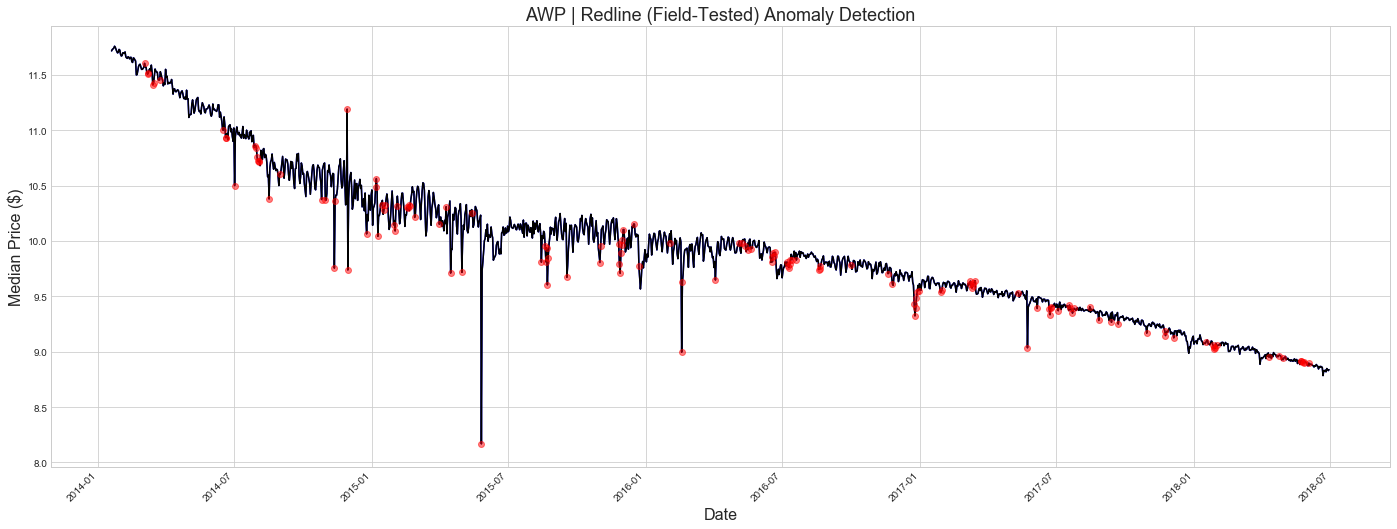

In [67]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(24,9))
fig.autofmt_xdate(rotation=45)
# ax.plot(anom_val.timestamp[31:], anom_val.median_sell_price[31:], zorder=1)
ax.plot(anom_val.timestamp[31:], model.predict_in_sample(start=1, exogenous=zero_quant, dynamic=True), c='blue', zorder=1)
ax.plot(anom_val.timestamp[31:], model.predict_in_sample(start=1, exogenous=anom_val['quantity'][31:].values.reshape(-1,1), dynamic=True), c='black', zorder=1)
# ax.scatter(results['anoms'].index, anom_val.median_sell_price[[t in results['anoms'].index for t in anom_val.timestamp.values]], c='red', alpha=0.5, zorder=2)
ax.scatter(results['anoms'].index, results['anoms']['anoms'], c='red', alpha=0.5, zorder=2)
ax.set_xlabel('Date', fontsize=16)
ax.set_ylabel('Median Price ($)', fontsize=16)
ax.set_title('AWP | Redline (Field-Tested) Anomaly Detection', fontsize=18)
model.summary()

In [68]:
import statsmodels.api as sm

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1625
Model:               SARIMAX(7, 1, 0)   Log Likelihood                -269.566
Date:                Tue, 13 Nov 2018   AIC                            559.132
Time:                        17:24:24   BIC                            613.058
Sample:                             0   HQIC                           579.142
                               - 1625                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0019      0.007     -0.261      0.794      -0.016       0.012
x1            -0.0008    2.2e-05    -36.005      0.000      -0.001      -0.001
ar.L1         -0.0918      0.022     -4.130      0.000      -0.135      -0.048
ar.L2         -0.1342      0.016     -8.156      0.000      -0.166      -0.102
ar.L3         -0.0448      0.024     -1.829      0.067      -0.093       0.003
ar.L4         -0.0152      0.024     -0.622      0.534      -0.063       0.033
ar.L5         -0.1009      0.024     -4.206      0.000      -0.148      -0.054
ar.L6         -0.0061      0.024     -0.251      0.802      -0.054       0.042
ar.L7          0.0857      0.025      3.372      0.001       0.036       0.136
sigma2         0.0817      0.002     51.180      0.000       0.079       0.085
===================================================================================
Ljung-Box (Q):                       89.75   Jarque-Bera (JB):              4153.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                        10.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

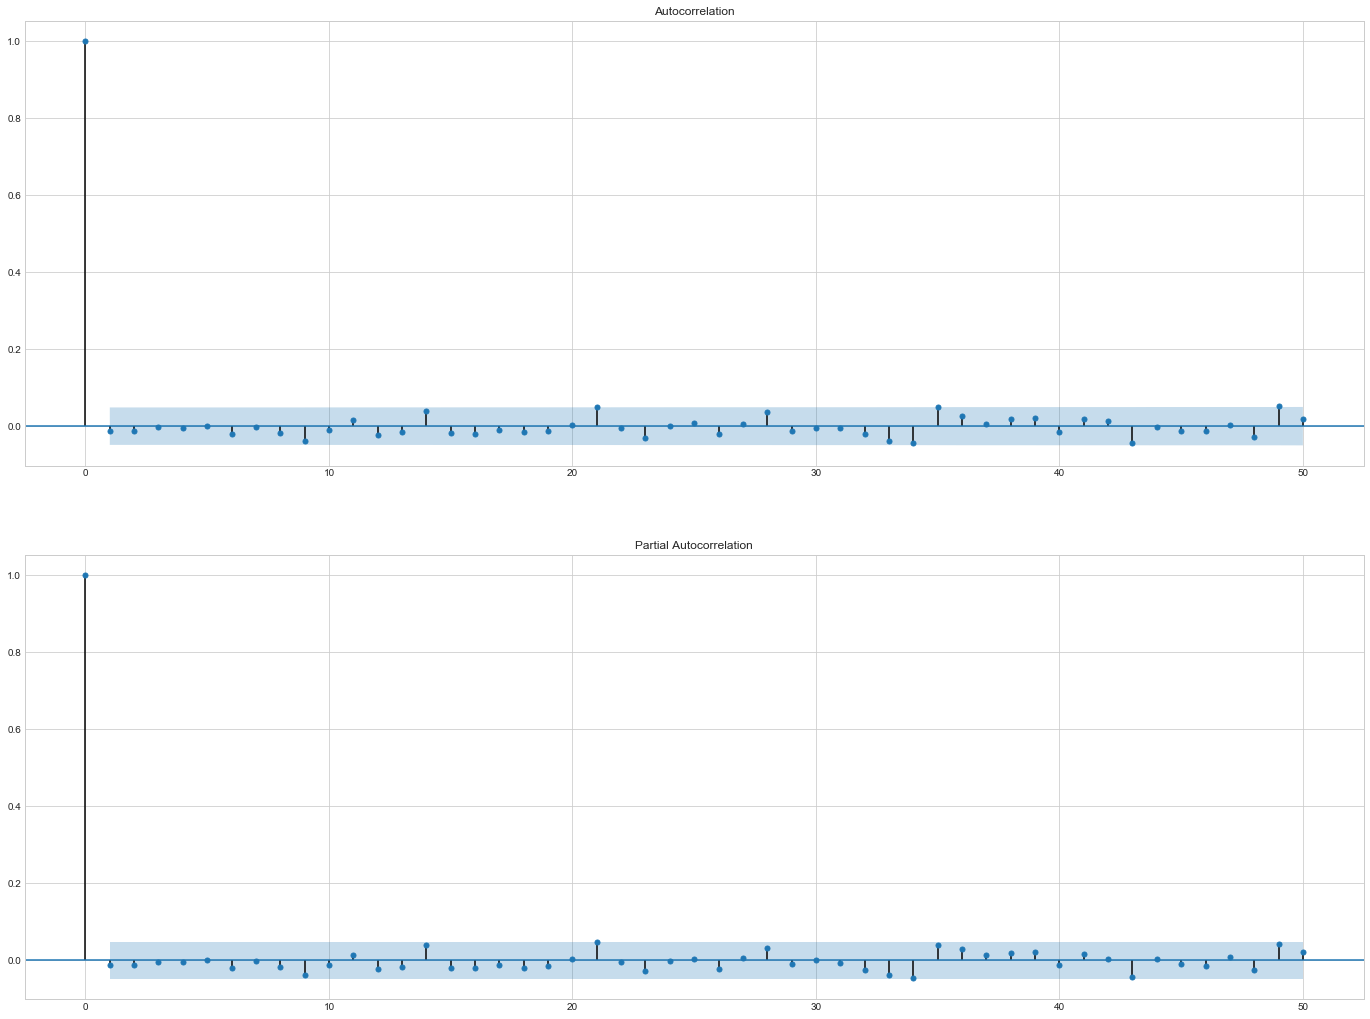

In [69]:
model = auto_arima(df_val['median_sell_price'][30:], start_p=7, max_p=10, max_q=10, max_order=20, exogenous=anom_val['quantity'][30:].values.reshape(-1,1))
fig, ax = plt.subplots(2,1,figsize=(24, 18))
sm.graphics.tsa.plot_acf(model.resid(), lags=50, ax=ax[0])
_=sm.graphics.tsa.plot_pacf(model.resid(), lags=50, ax=ax[1])
model.summary()

In [70]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1625
Model:               SARIMAX(7, 1, 0)   Log Likelihood                -269.566
Date:                Tue, 13 Nov 2018   AIC                            559.132
Time:                        17:24:25   BIC                            613.058
Sample:                             0   HQIC                           579.142
                               - 1625                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0019      0.007     -0.261      0.794      -0.016       0.012
x1            -0.0008    2.2e-05    -36.005      0.000      -0.001      -0.001
ar.L1         -0.0918      0.022     -4.130      0.000      -0.135      -0.048
ar.L2         -0.1342      0.016     -8.156      0.000      -0.166      -0.102
ar.L3         -0.0448      0.024     -1.829      0.067      -0.093       0.003
ar.L4         -0.0152      0.024     -0.622      0.534      -0.063       0.033
ar.L5         -0.1009      0.024     -4.206      0.000      -0.148      -0.054
ar.L6         -0.0061      0.024     -0.251      0.802      -0.054       0.042
ar.L7          0.0857      0.025      3.372      0.001       0.036       0.136
sigma2         0.0817      0.002     51.180      0.000       0.079       0.085
===================================================================================
Ljung-Box (Q):                       89.75   Jarque-Bera (JB):              4153.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                        10.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1625
Model:               SARIMAX(3, 1, 8)   Log Likelihood                -259.411
Date:                Tue, 13 Nov 2018   AIC                            546.823
Time:                        17:24:53   BIC                            622.320
Sample:                             0   HQIC                           574.836
                               - 1625                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0005      0.008     -0.065      0.948      -0.016       0.015
x1            -0.0008   2.19e-05    -36.364      0.000      -0.001      -0.001
ar.L1         -0.0210      0.753     -0.028      0.978      -1.497       1.455
ar.L2         -0.7043      0.277     -2.541      0.011      -1.248      -0.161
ar.L3          0.3318      0.629      0.527      0.598      -0.902       1.565
ma.L1         -0.0701      0.754     -0.093      0.926      -1.548       1.408
ma.L2          0.5895      0.213      2.766      0.006       0.172       1.007
ma.L3         -0.4325      0.521     -0.830      0.406      -1.453       0.588
ma.L4         -0.0552      0.115     -0.478      0.632      -0.281       0.171
ma.L5         -0.0606      0.086     -0.703      0.482      -0.230       0.108
ma.L6          0.0200      0.076      0.262      0.793      -0.129       0.169
ma.L7          0.0203      0.036      0.565      0.572      -0.050       0.091
ma.L8          0.0333      0.031      1.058      0.290      -0.028       0.095
sigma2         0.0811      0.002     50.877      0.000       0.078       0.084
===================================================================================
Ljung-Box (Q):                       61.75   Jarque-Bera (JB):              4477.42
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.03
Prob(H) (two-sided):                  0.01   Kurtosis:                        11.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

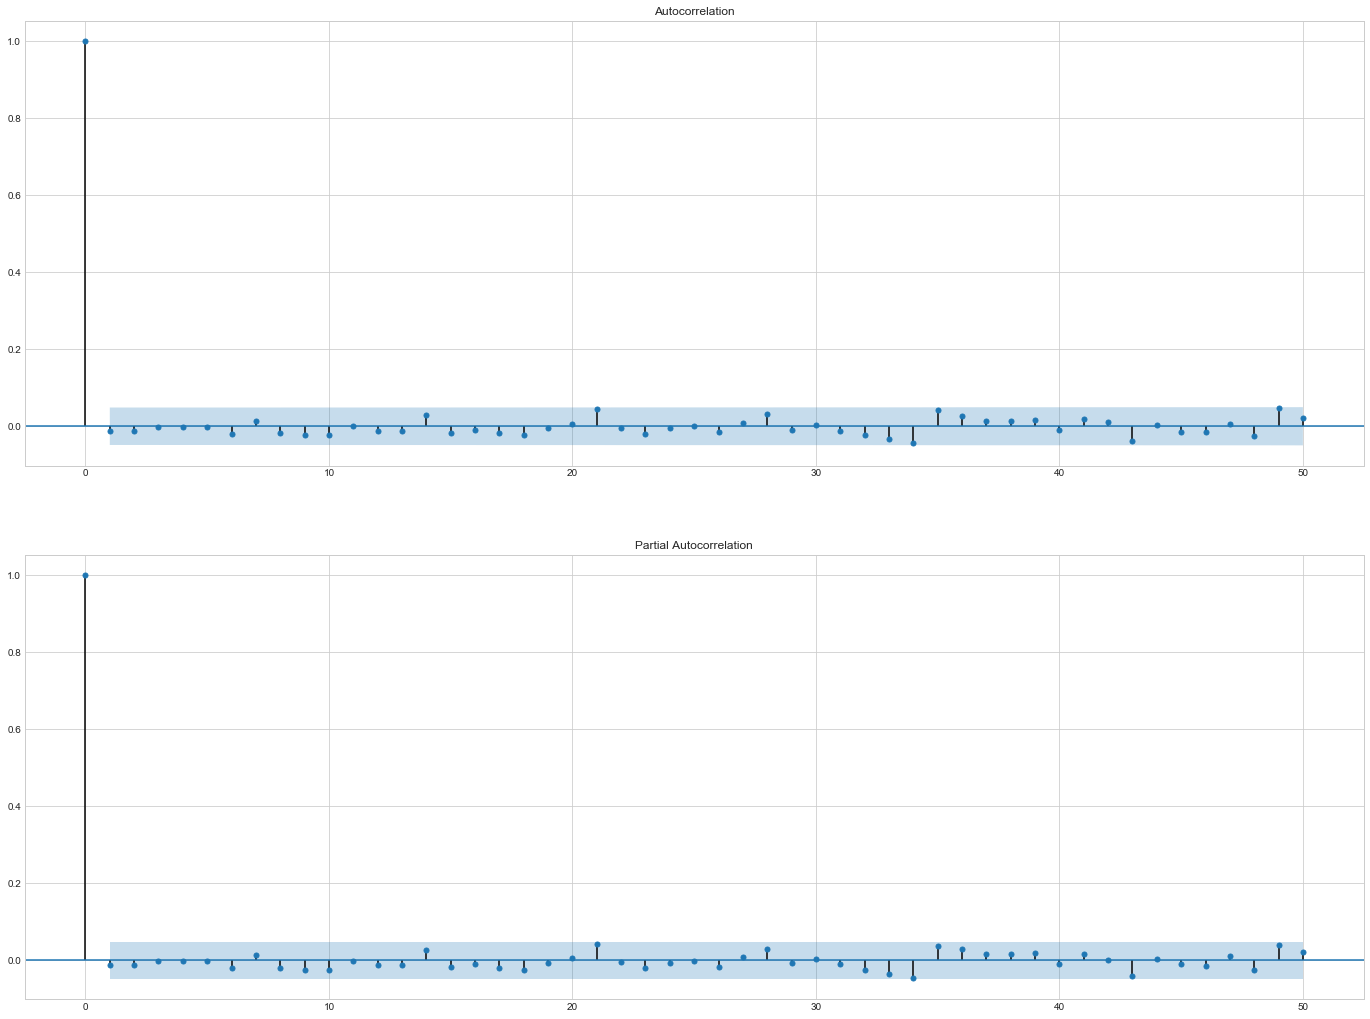

In [71]:
model = auto_arima(df_val['median_sell_price'][30:], start_q=7, max_p=10, max_q=10, max_order=20, exogenous=anom_val['quantity'][30:].values.reshape(-1,1))
fig, ax = plt.subplots(2,1,figsize=(24, 18))
sm.graphics.tsa.plot_acf(model.resid(), lags=50, ax=ax[0])
_=sm.graphics.tsa.plot_pacf(model.resid(), lags=50, ax=ax[1])
model.summary()

In [72]:
model = auto_arima(df_val['median_sell_price'][30:], start_p=0, start_q=0, d=None,
                   max_p=10, max_q=10, max_d=10, max_order=20, stepwise=False, n_jobs=-1, m=12, error_action='ignore')
fig, ax = plt.subplots(2,1,figsize=(24, 18))
sm.graphics.tsa.plot_acf(model.resid(), lags=50, ax=ax[0])
_=sm.graphics.tsa.plot_pacf(model.resid(), lags=50, ax=ax[1])
model.summary()

KeyboardInterrupt: 

In [ ]:
model = auto_arima(df_val['median_sell_price'][30:], start_p=0, start_q=0, d=None,
                   max_p=10, max_q=10, max_d=10, max_order=20, m=4, exogenous=anom_val['quantity'][30:].values.reshape(-1,1),
                   stepwise=False, n_jobs=-1, error_action='ignore')
fig, ax = plt.subplots(2,1,figsize=(24, 18))
sm.graphics.tsa.plot_acf(model.resid(), lags=50, ax=ax[0])
_=sm.graphics.tsa.plot_pacf(model.resid(), lags=50, ax=ax[1])
model.summary()

In [ ]:
model = auto_arima(df_val['median_sell_price'][30:], start_p=0, start_q=2, d=1,
                   max_p=10, max_q=10, max_d=10, max_order=20, m=1, exogenous=anom_val['quantity'][30:].values.reshape(-1,1),
                   stepwise=False, n_jobs=-1, error_action='ignore', random=True)
model.summary()

In [ ]:
endog = df_val['median_sell_price'][30:]
exog = anom_val['quantity'][30:]

In [ ]:
endog.index = df_val['timestamp'][30:]
exog.index = anom_val['timestamp'][30:]

In [ ]:
manual_arima = ARIMA(endog, order=(0,1,2))

In [ ]:
manual_arima = manual_arima.fit()

In [ ]:
fig, ax = plt.subplots(figsize=(20,9))
ax.plot(endog.index[1:], manual_arima.predict(typ='levels'))
ax.plot(endog.index[1:], model.predict_in_sample(exogenous=exog.values.reshape(-1,1), start=1))

In [ ]:
model.summary()

In [ ]:
df_val.head()

In [ ]:
anom_val.head()